Imports

In [2]:
#Import ximea (camera software)
import sys
sys.path.append('C:/XIMEA/API/Python/v3')

import ximea
print('ximea version ', ximea.__version__)
from ximea import xiapi

#import useful things
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

# Import HS classes assuming they reside one directory above
hspath = os.path.abspath('..')
if hspath not in sys.path:
    sys.path.append(hspath)

sys.path.append('C:/Users/katel/OneDrive/Documents/Summer Scolarship/')
from HS_Image import *
from HWS.HS_Centroids import *
from HWS.HS_Gradients import *
from HWS.HS_WFP import *
import HWS.HSM_WFN as HSM_WFN

import time


ximea version  4.28.00


User Options

In [ ]:
# number of frames to take and average
N = 1000

# time to warm up before taking data
T = 7200 #  2 hours in seconds

folder_name = 'centroids_2_hours'
file_path = os.getcwd()

camera

In [ ]:
cam = xiapi.Camera()
cam.open_device()

#settings
exposure = 3000
img_size = 2048
cam.set_exposure(exposure)

Functions

In [ ]:
def take_and_average_frames(cam, n):
    """_summary_

    Args:
        cam (_type_): _xiapi.camera_
        N (_int_): _number_of_frames_

    Returns:
        _np.array_: _average_image_
    """
    
    img = xiapi.Image()
    temp = np.zeros((img_size, img_size))
    for i in range(N):
        cam.get_image(img)
        temp += img.get_image_data_numpy()

    return (temp / N)

In [ ]:
def find_cent_position_ref(cam, n, background):
    '''find the centroids which will be used as a reference to find all other centroids'''
    #start data acquisition
    cam.start_acquisition()
    #take and average images
    reference_image = take_and_average_frames(cam, n)
    #stop data acquisition
    cam.stop_acquisition()
    # find reference centroids
    hsi_ref = HS_Image()
    hsi_ref.background = background
    hsi_ref.original_image = reference_image
    hsi_ref.original_image.shape = (2048, 2048)
    hsi_ref.process_image()
    hsc_ref = HS_Centroids()
    hsc_ref.hsimage = hsi_ref
    hsc_ref.find_centroids_from_image(to_filter_spots = True, size_threshold = 50)
    ref_centroids = hsc_ref.centroids
    return ref_centroids

In [ ]:
def record_temperature_of_camera(T):
    '''turn on a ximea camera and take but do not save images. Record the temperature of the camera each second'''
    img = xiapi.Image()
    time_list = np.zeros(T)
    temperature_list = np.zeros(T)
    cam.start_acquisition()
    for i in range(T):
        time.sleep(1)
        cam.get_image(img)
        time_list[i] = time.time()
        temperature_list[i] = cam.get_temp()
    cam.stop_acquisition()
    return time_list, temperature_list

background

In [15]:
#take and average background frames
if os.path.exists(os.path.join(file_path, f'background.npy')):
    print('background already taken')
else:
    time.sleep(60)
    #cam.stop_acquisition()
    cam.start_acquisition()

    #take and average images
    background = take_and_average_frames(cam, 100)
    average_background = np.mean(background)
    background[493, 1745] = average_background # get that nonsense pixel gone
    background.shape = (img_size, img_size)

    cam.stop_acquisition()

    np.save(os.path.join(file_path, f'background'), background)

background already taken


In [16]:
background = np.load(os.path.join(file_path, f'background.npy'))
background.shape = (2048, 2048)
# cam.stop_acquisition()

In [17]:
def take_and_save_centroids(cam, N, folder_name=''):
    img = xiapi.Image()
    for i in range(N):
        cam.get_image(img)
        image = img.get_image_data_numpy()

        hsi_live = HS_Image()
        hsi_live.background = background
        hsi_live.original_image = image
        hsi_live.original_image.shape = (2048, 2048)

        hsi_live.process_image()

        hsc_live = HS_Centroids()
        hsc_live.hsimage = hsi_live
        hsc_live.find_centroids(hsc_ref.centroids)
        
        centroids = hsc_live.centroids

        np.save(os.path.join(file_path, os.path.join(folder_name, f'centroids{i}')), centroids)


# take and save centroids

In [ ]:
run = False

if run == True:

    time_list, temperature_list = record_temperature_of_camera(T)
    print('warm-up complete')

    pos_ref_cents = find_cent_position_ref(cam, 10, background)

    file_path = os.getcwd()
    os.makedirs(os.path.join(file_path, folder_name))

    #take and save centroids
    time_i = time.time()
    cam.start_acquisition()
    centroids = take_and_save_centroids(cam,N,folder_name)
    cam.stop_acquisition()
    time_f = time.time()
    seconds_ellapsed = time_f - time_i
    print('live centroids saved')
    print('seconds ellapsed =', seconds_ellapsed)

warm-up complete
reference centroids saved
live centroids saved
seconds ellapsed = 3.5436947345733643


In [19]:
cam.stop_acquisition()
cam.close_device()

In [20]:
time_temp_table = np.array([[time_list], [temperature_list]])
print(np.shape(time_temp_table))
np.save(os.path.join(file_path, os.path.join(folder_name, 'camera_temperature')), time_temp_table)

(2, 1, 10)


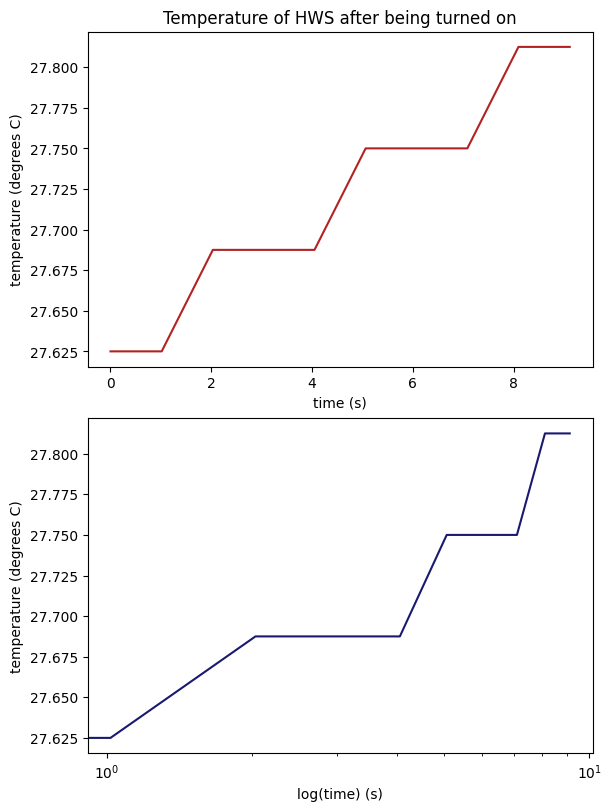

In [22]:
# load data to plot
plot_1 = np.load(os.path.join(file_path, os.path.join(folder_name, 'camera_temperature.npy'))) 

initial_time_1 = plot_1[0, 0, 0] # time when data recording commenced
seconds_1 = plot_1[0, 0, :] - initial_time_1 # rescale x axis so time zero is when data recording began
degrees_1 = plot_1[1, 0, :] # the temperature

fig, ax1 = plt.subplots(2, 1, layout='constrained', figsize = (6, 8))

plt.subplot(2, 1, 1)
plt.plot(seconds_1, degrees_1, color = 'firebrick')
plt.title('Temperature of HWS after being turned on')
plt.xlabel('time (s)')
plt.ylabel('temperature (degrees C)')

plt.subplot(2, 1, 2)
plt.semilogx(seconds_1, degrees_1, color = 'midnightblue')
# plt.title('Temperature of HWS after being turned on')
plt.xlabel('log(time) (s)')
plt.ylabel('temperature (degrees C)')

plt.show()
